In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
# параметры распределений
mu0, cov0 = [-2., -1.], [[1., 0.9], [0.9, 1.]]
mu1, cov1 = [3., 1.], [[1., 0.1], [0.1, 1.]]

In [3]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [4]:
d0 = torch.distributions.MultivariateNormal(torch.tensor(mu0), torch.tensor(cov0))
d1 = torch.distributions.MultivariateNormal(torch.tensor(mu1), torch.tensor(cov1))

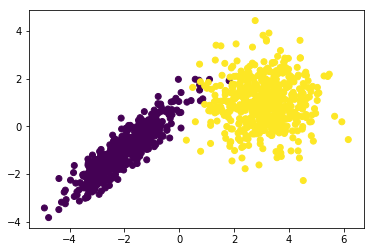

In [7]:
x, y = sample(d0, d1, 512)
plt.scatter(x[:,0], x[:,1], c=y.flatten())
plt.show()

In [8]:
layer = nn.Linear(2, 1) # Два входа
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([ 0.3924, -0.2129]), tensor(-0.6949)]


In [9]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.420923
Ошибка после 1 итераций: 0.221229
Ошибка после 2 итераций: 0.157417
Ошибка после 3 итераций: 0.126482
Ошибка после 4 итераций: 0.107865
Ошибка после 5 итераций: 0.096001
Ошибка после 6 итераций: 0.087181
Ошибка после 7 итераций: 0.080517
Ошибка после 8 итераций: 0.075712
Ошибка после 9 итераций: 0.071853
Ошибка после 10 итераций: 0.067902
Ошибка после 11 итераций: 0.064451
Ошибка после 12 итераций: 0.062720
Ошибка после 13 итераций: 0.060179
Ошибка после 14 итераций: 0.058466
Ошибка после 15 итераций: 0.056607
Ошибка после 16 итераций: 0.055138
Ошибка после 17 итераций: 0.054058
Ошибка после 18 итераций: 0.052153
Ошибка после 19 итераций: 0.051706


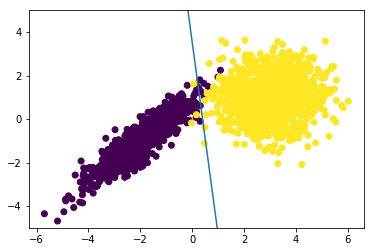

In [10]:
# Визуализация разделяющей прямой

coefs = [p[0] for p in layer.parameters()]
b1 = float(coefs[0][0])
b2 = float(coefs[0][1])
b0 = float(coefs[1])

x, y = sample(d0, d1, 1024)

plt.scatter(x[:,0], x[:,1], c=y.flatten())

xrange = np.array([-4, 6])
line = -(b1 * xrange + b0) / b2
plt.plot(xrange, line)
plt.ylim(-5,5)

plt.show()

<IPython.core.display.Javascript object>


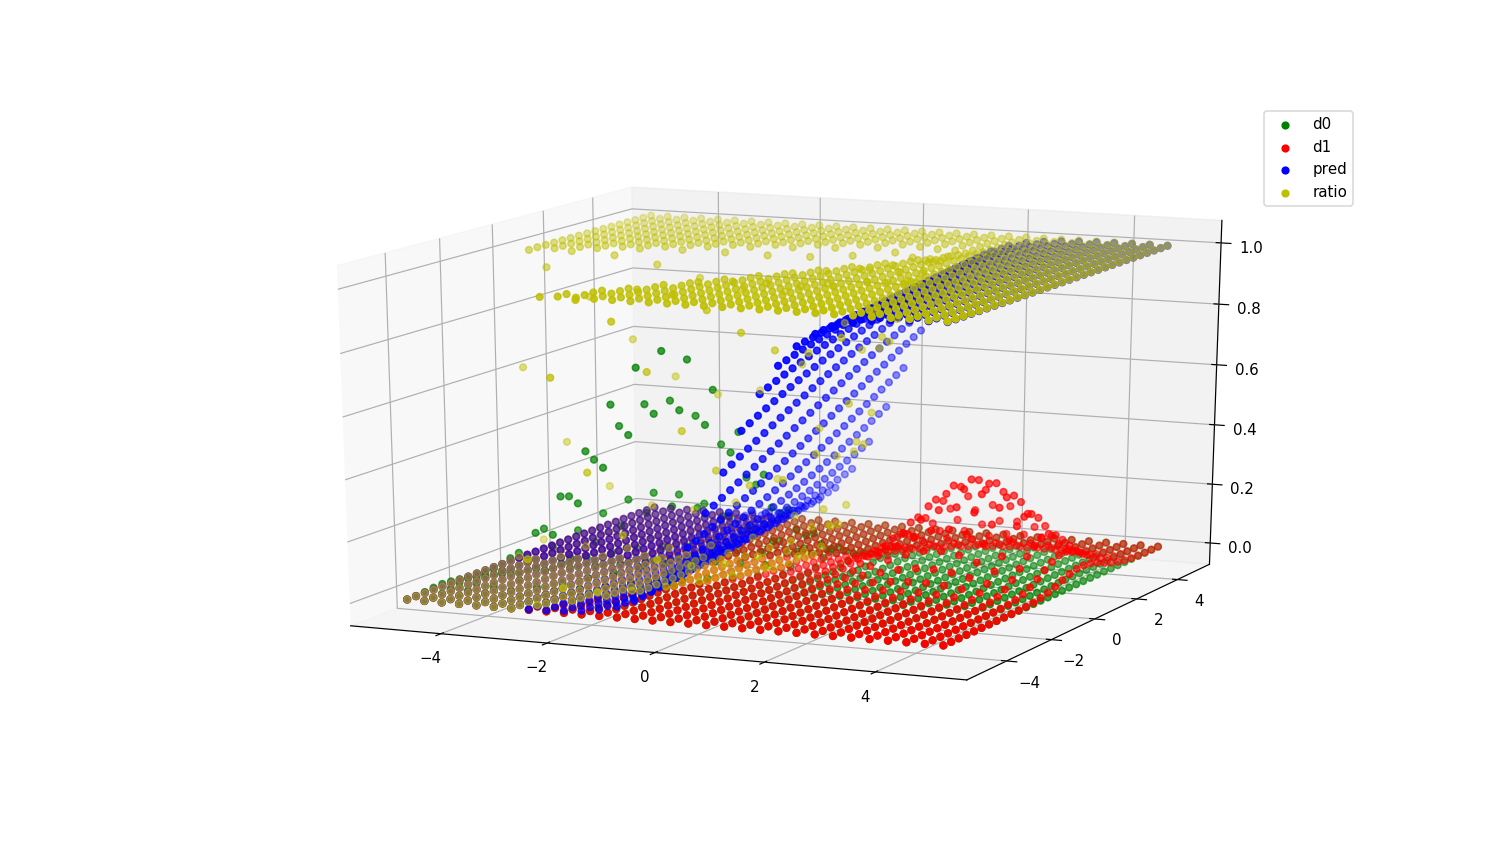

In [12]:
# Перевод в трехмерное пространство
# графика с предсказанными значениями и отношениями

%matplotlib notebook

x_scale, y_scale = np.mgrid[-5:5:.33, -5:5:.33]
pos = np.empty(x_scale.shape + (2,))
pos[:, :, 0] = x_scale; pos[:, :, 1] = y_scale
rv0 = stats.multivariate_normal(mu0, cov0)
rv1 = stats.multivariate_normal(mu1, cov1)

plt.figure(figsize=(14,8))
ax = plt.axes(projection='3d')
ax.scatter3D(x_scale, y_scale, rv0.pdf(pos)*2, c="g", label="d0");
ax.scatter3D(x_scale, y_scale, rv1.pdf(pos)*2, c="r", label="d1");

with torch.no_grad():
    dist = torch.sigmoid(layer(torch.stack([torch.tensor(x_scale.flatten()).float(), 
                                            torch.tensor(y_scale.flatten()).float()], 1))).numpy()
    
ax.scatter3D(x_scale, y_scale, dist, c="b", label="pred");   
ratio = rv1.pdf(pos) / (rv0.pdf(pos) + rv1.pdf(pos))
ax.scatter3D(x_scale, y_scale, ratio, c="y", label="ratio"); 
plt.legend()
plt.show()